<a href="https://colab.research.google.com/github/Alejix/DataScience/blob/main/Modelos_Regresivos_SARIMAX.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PIP

In [ ]:
!pip install pmdarima
!pip install skforecast

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 11.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 397.3/397.3 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.1/77.1 kB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 390.6/390.6 kB 14.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.0/226.0 kB 13.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 10.1 MB/s eta 0:00:00
  Attempting uninstall: tqdm
    Found existing installation: tqdm 4.66.1
    Uninstalling tqdm-4.66.1:
      Successfully uninstalled tqdm-4.66.1


# Librerías

In [ ]:
#Tratamiento de datos y gráficos
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#Pmdarima
from pmdarima import ARIMA
from pmdarima import auto_arima

#Statsmodels
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose

#Skforecast
from skforecast.Sarimax import Sarimax
from skforecast.ForecasterSarimax import ForecasterSarimax

#Métricas
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_absolute_error

#Mecanismos de ajusto
from skforecast.model_selection_sarimax import backtesting_sarimax
from skforecast.model_selection_sarimax import grid_search_sarimax

#Advertencias
import warnings

In [ ]:
plt.style.use('seaborn-v0_8-darkgrid')
warnings.filterwarnings('ignore')

# Datos

Resumen del consumo mensual de combustibles en España

In [ ]:
url ='https://raw.githubusercontent.com/JoaquinAmatRodrigo/Estadistica-machine-learning-python/master/data/consumos-combustibles-mensual.csv'
datos = pd.read_csv(url, sep= ',')
datos.head()

,Fecha,GLPs,Gasolinas,Querosenos,Gasoleos,Fueloleos
0,1969-01-01,133615.09620,166875.2129,123257.8090,401185.2939,912583.4202
1,1969-02-01,126748.47410,155466.8105,114682.5767,385360.0381,851877.8115
2,1969-03-01,107795.80910,184983.6699,109970.0796,418955.5808,873884.2933
3,1969-04-01,96683.15967,202319.8164,108797.9255,438975.5445,755490.1170
4,1969-05-01,79506.23804,206259.1523,103554.0784,467451.9469,729963.6009


In [ ]:
datos = datos[['Fecha', 'Gasolinas']]
datos = datos.rename(columns = {'Fecha':'date', 'Gasolinas':'litters'})
datos['date'] = pd.to_datetime(datos['date'], format = '%Y/%m/%d')
datos = datos.set_index('date')
datos.head()

,litters
date,
1969-01-01,166875.2129
1969-02-01,155466.8105
1969-03-01,184983.6699
1969-04-01,202319.8164
1969-05-01,206259.1523


In [ ]:
datos = datos.loc[:'1990-01-01'] #Extraer los datos desde el primer dato hasta esta fecha.
datos

,litters
date,
1969-01-01,166875.2129
1969-02-01,155466.8105
1969-03-01,184983.6699
1969-04-01,202319.8164
1969-05-01,206259.1523
...,...
1989-09-01,687649.2852
1989-10-01,669889.1602
1989-11-01,601413.8867


In [ ]:
#Volvemos el dataframe una serie:
datos = datos.asfreq('MS')
datos = datos['litters']
type(datos)

pandas.core.series.Series

Crear un conjunto de ajuste y conjunto de validación

In [ ]:
fin_ajuste = '1980-01-01'
print(f'Fechas ajuste : {datos.index.min()} --- {datos.loc[:fin_ajuste].index.max()} (n = {len(datos.loc[:fin_ajuste])})')
print(f'Fechas validación : {datos.loc[fin_ajuste:].index.min()} --- {datos.loc[:].index.max()} (n = {len(datos.loc[fin_ajuste:])})')

Fechas ajuste : 1969-01-01 00:00:00 --- 1980-01-01 00:00:00 (n = 133)
Fechas validación : 1980-01-01 00:00:00 --- 1990-01-01 00:00:00 (n = 121)


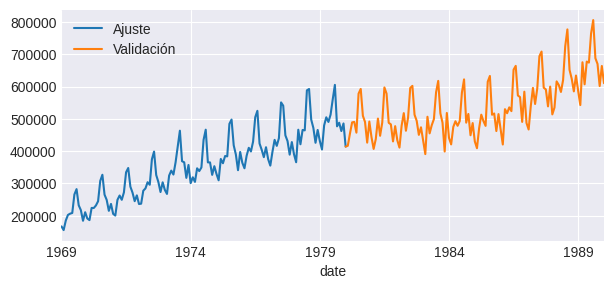

In [ ]:
datos_ajuste = datos.loc[:fin_ajuste]
datos_validacion = datos.loc[fin_ajuste:]
plt.figure(figsize = (7, 3))
datos_ajuste.plot(label = 'Ajuste')
datos_validacion.plot(label = 'Validación')
plt.legend()
plt.show()

Los datos azules son los que usaremos para ajustar el modelo.
Los datos rojos son con los que validaremos el desempeño del modelo.

# Análisis SARIMA
1. Estacionariedad
2. Autocorrelación
3. Descomposición

Estacionariedad:
- Test Dickey - Fuller
- Test KPSS

Diferenciamos la serie hasta que cumplamos con las dos pruebas estadisticas.

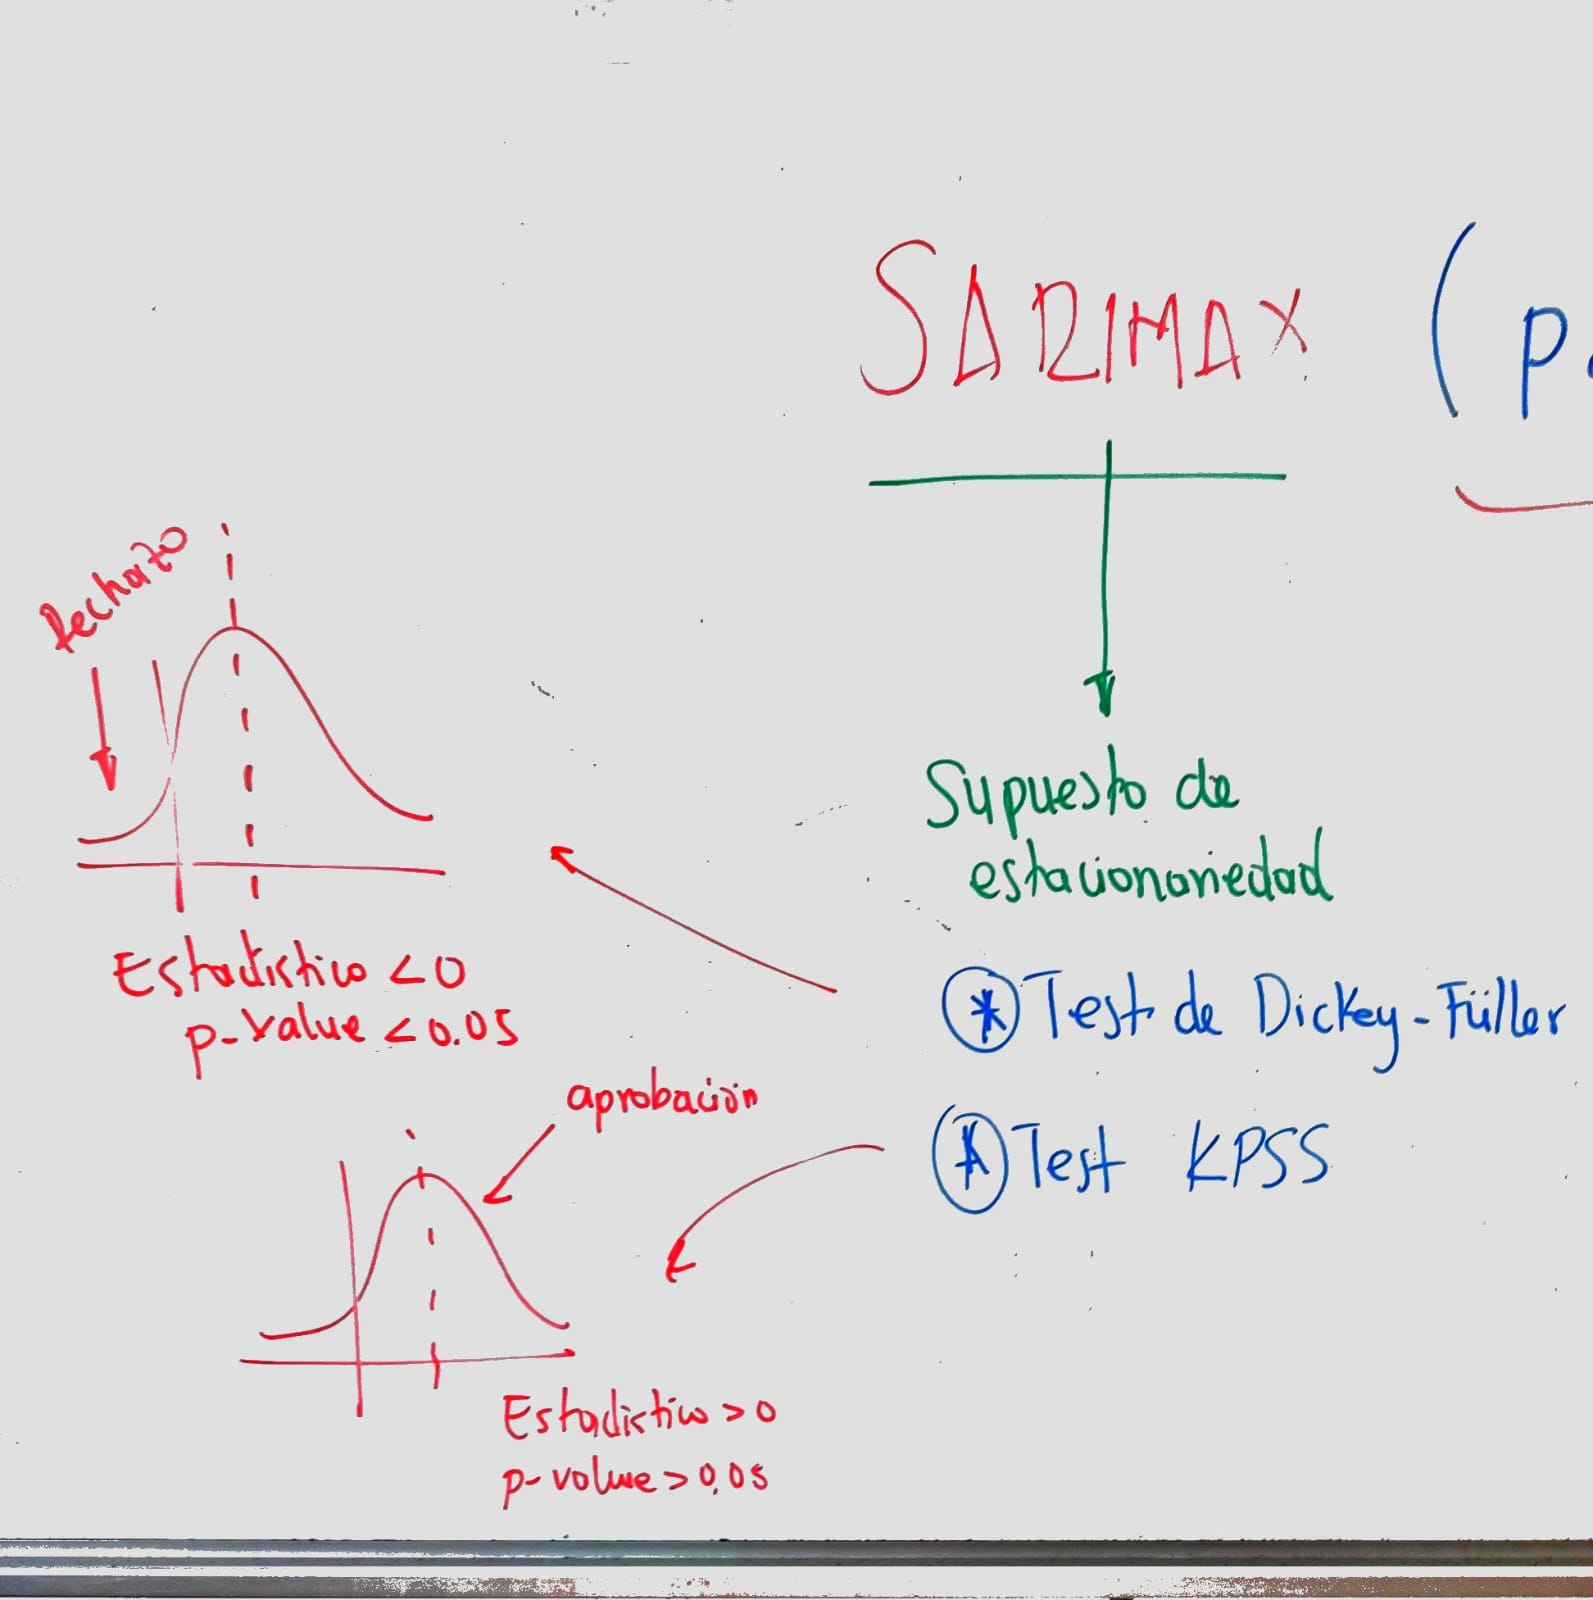

In [ ]:
print('Test de estacionariedad para la serie original')
print('----------------------------------------------')
adfuller_result = adfuller(datos)
kpss_result = kpss(datos)
print(f'Estadístico ADF: {adfuller_result[0]}, p-value: {adfuller_result[1]}')
print(f'Estadístico KPSS: {kpss_result[0]}, p-value: {kpss_result[1]}')

Test de estacionariedad para la serie original
----------------------------------------------
Estadístico ADF: -0.44612980998227997, p-value: 0.9021071923942665
Estadístico KPSS: 2.2096370946978383, p-value: 0.01


In [ ]:
datos_diff_1 = datos.diff().dropna()
print('Test de estacionariedad para la serie diferenciada en orden 1')
print('-------------------------------------------------------------')
adfuller_result = adfuller(datos_diff_1)
kpss_result = kpss(datos_diff_1)
print(f'Estadístico ADF: {adfuller_result[0]}, p-value: {adfuller_result[1]}')
print(f'Estadístico KPSS: {kpss_result[0]}, p-value: {kpss_result[1]}')

Test de estacionariedad para la serie diferenciada en orden 1
-------------------------------------------------------------
Estadístico ADF: -2.459285585433223, p-value: 0.1256973823175177
Estadístico KPSS: 0.313271162357279, p-value: 0.1


In [ ]:
datos_diff_2 = datos_diff_1.diff().dropna()
print('Test de estacionariedad para la serie diferenciada en orden 1')
print('-------------------------------------------------------------')
adfuller_result = adfuller(datos_diff_2)
kpss_result = kpss(datos_diff_2)
print(f'Estadístico ADF: {adfuller_result[0]}, p-value: {adfuller_result[1]}')
print(f'Estadístico KPSS: {kpss_result[0]}, p-value: {kpss_result[1]}')

Test de estacionariedad para la serie diferenciada en orden 1
-------------------------------------------------------------
Estadístico ADF: -11.117483376374423, p-value: 3.533286742437504e-20
Estadístico KPSS: 0.08065668267482215, p-value: 0.1


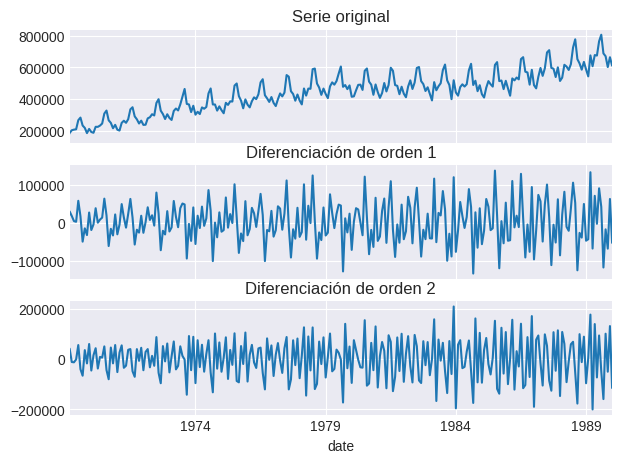

In [ ]:
#Gráfico de las series
fig, ax = plt.subplots(3, 1, figsize = (7, 5), sharex = True) #Sharex = True evita que los titulos se superpongan con el eje
datos.plot(ax = ax[0], title = 'Serie original')
datos_diff_1.plot(ax = ax[1], title = 'Diferenciación de orden 1')
datos_diff_2.plot(ax = ax[2], title = 'Diferenciación de orden 2')
plt.show()

Autocorrelación:
- ACF
- PACF

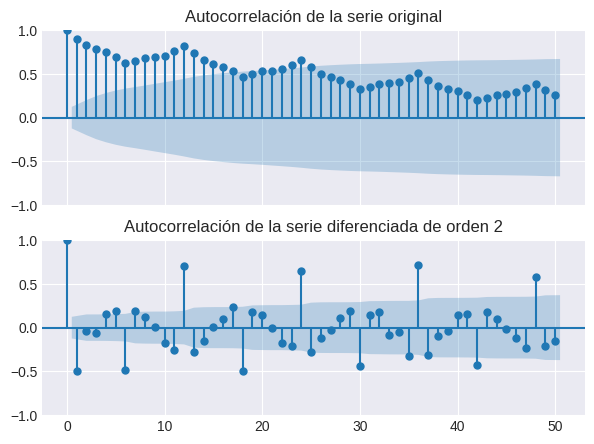

In [ ]:
fig, ax = plt.subplots(2, 1, figsize = (7, 5), sharex = True)
plot_acf(datos, ax = ax[0], lags = 50)
ax[0].set_title('Autocorrelación de la serie original')
plot_acf(datos_diff_2, ax = ax[1], lags = 50)
ax[1].set_title('Autocorrelación de la serie diferenciada de orden 2')
plt.show()

El valor q es 1, que son los rezagos que me cumplen con estar afuera del area azul antes del primero que esté adentro. (No se cuenta el primer valor, pues es correlación con uno mismo.)

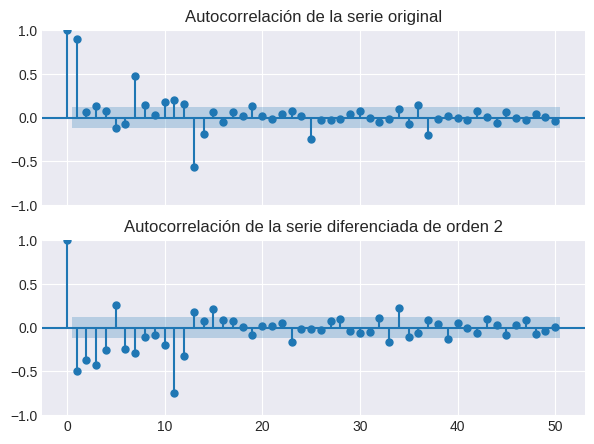

In [ ]:
fig, ax = plt.subplots(2, 1, figsize = (7, 5), sharex = True)
plot_pacf(datos, ax = ax[0], lags = 50)
ax[0].set_title('Autocorrelación de la serie original')
plot_pacf(datos_diff_2, ax = ax[1], lags = 50)
ax[1].set_title('Autocorrelación de la serie diferenciada de orden 2')
plt.show()

El valor p es 8.

Descomposición
- Tendencia
- Estacionalidad
- Aleatoriedad

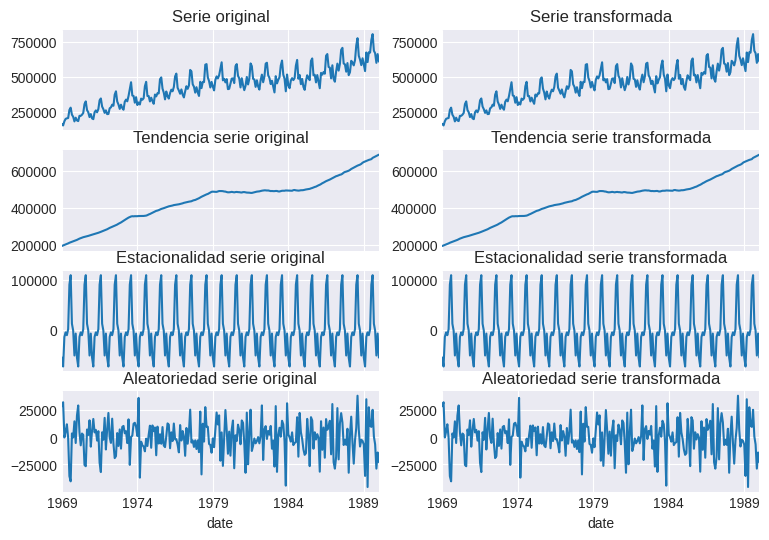

In [ ]:
res_decompose = seasonal_decompose(datos, model = 'additive', extrapolate_trend = 'freq')
res_decompose_diff_2 = seasonal_decompose(datos, model = 'additive', extrapolate_trend = 'freq')

fig, ax = plt.subplots(4, 2, figsize = (9, 6), sharex = True)
res_decompose.observed.plot(ax = ax[0,0])
ax[0,0].set_title('Serie original')
res_decompose.trend.plot(ax = ax[1,0])
ax[1,0].set_title('Tendencia serie original')
res_decompose.seasonal.plot(ax = ax[2,0])
ax[2,0].set_title('Estacionalidad serie original')
res_decompose.resid.plot(ax = ax[3,0])
ax[3,0].set_title('Aleatoriedad serie original')
res_decompose_diff_2.observed.plot(ax = ax[0,1])
ax[0,1].set_title('Serie transformada')
res_decompose_diff_2.trend.plot(ax = ax[1,1])
ax[1,1].set_title('Tendencia serie transformada')
res_decompose_diff_2.seasonal.plot(ax = ax[2,1])
ax[2,1].set_title('Estacionalidad serie transformada')
res_decompose_diff_2.resid.plot(ax = ax[3,1])
ax[3,1].set_title('Aleatoriedad serie transformada')
plt.show()

Como transformamos la serie dos veces, d y D son igual a 2

Como la serie es mensual, y se repite cada 12 periodos el mismo patros, la frecuencia del muestreo es 12 (f).

In [ ]:
datos_diff_2_12 = datos_diff_2.diff(12).dropna()
adfuller_result = adfuller(datos_diff_2_12)
print(f'ADF Statistic: {adfuller_result[0]}, p-value: {adfuller_result[1]}')
kpss_result = kpss(datos_diff_2_12)
print(f'KPSS Statistic: {kpss_result[0]}, p-value: {kpss_result[1]}')

ADF Statistic: -6.330635011377937, p-value: 2.9122529506081544e-08
KPSS Statistic: 0.05684938966942584, p-value: 0.1


Con estos cambios nuestra serie se vuelve estacionaria. Las metricas cumplen con los criterios de estacionalidad.

<Figure size 700x300 with 0 Axes>

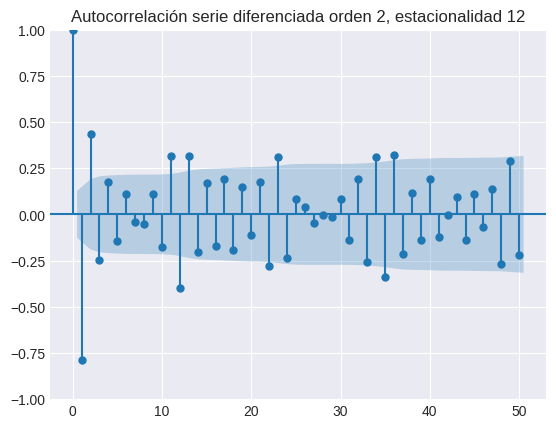

In [ ]:
plt.figure(figsize=(7,3))
plot_acf(datos_diff_2_12, lags = 50)
plt.title('Autocorrelación serie diferenciada orden 2, estacionalidad 12')
plt.show()

El primer valor no se tiene en cuenta. Por esta gráfica concluímos que Q es 3.

<Figure size 700x300 with 0 Axes>

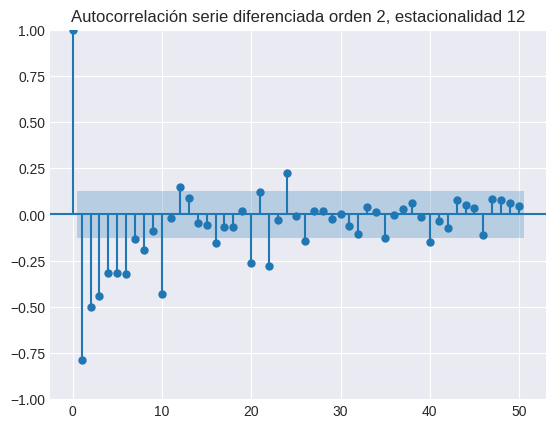

In [ ]:
plt.figure(figsize=(7,3))
plot_pacf(datos_diff_2_12, lags = 50, method='ywm')
plt.title('Autocorrelación serie diferenciada orden 2, estacionalidad 12')
plt.show()

El valor de P es 8.

# Yt = SARIMA(8, 2, 1) (8, 2, 3, 12)
#              (p, d, q)   (P, D, Q, F)

In [ ]:
#Modelo SARIMA
modelo = SARIMAX(endog = datos_ajuste, order = (8,2,1), seasonal_order = (8,2,3,12))
modelo_res = modelo.fit(disp = 0)

In [ ]:
modelo_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                         SARIMAX Results                                          
==================================================================================================
Dep. Variable:                                    litters   No. Observations:                  133
Model:             SARIMAX(8, 2, 1)x(8, 2, [1, 2, 3], 12)   Log Likelihood               -1229.852
Date:                                    Thu, 28 Sep 2023   AIC                           2501.704
Time:                                            23:18:48   BIC                           2557.834
Sample:                                        01-01-1969   HQIC                          2524.459
                                             - 01-01-1980                                         
Covariance Type:                                      opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9180      0.475     -1.935      0.053      -1.848       0.012
ar.L2         -0.4435      0.736     -0.603      0.547      -1.886       0.999
ar.L3         -0.3621      0.734     -0.493      0.622      -1.801       1.077
ar.L4         -0.3657      0.782     -0.468      0.640      -1.898       1.166
ar.L5         -0.2898      0.833     -0.348      0.728      -1.923       1.343
ar.L6         -0.1201      0.830     -0.145      0.885      -1.748       1.508
ar.L7         -0.0486      0.717     -0.068      0.946      -1.454       1.357
ar.L8          0.0565      0.443      0.127      0.899      -0.813       0.926
ma.L1         -0.8086      0.373     -2.165      0.030      -1.541      -0.077
ar.S.L12      -0.5075    344.214     -0.001      0.999    -675.154     674.139
ar.S.L24      -0.1942    121.425     -0.002      0.999    -238.183     237.794
ar.S.L36      -0.3081    208.234     -0.001      0.999    -408.439     407.823
ar.S.L48      -0.2541    142.703     -0.002      0.999    -279.946     279.438
ar.S.L60      -0.2874    110.949     -0.003      0.998    -217.744     217.169
ar.S.L72      -0.1176     95.207     -0.001      0.999    -186.720     186.485
ar.S.L84      -0.0279     30.686     -0.001      0.999     -60.171      60.115
ar.S.L96      -0.0076     19.623     -0.000      1.000     -38.468      38.453
ma.S.L12      -0.5051    344.395     -0.001      0.999    -675.507     674.497
ma.S.L24      -0.1652    227.715     -0.001      0.999    -446.478     446.147
ma.S.L36       0.3341    139.280      0.002      0.998    -272.649     273.317
sigma2      9.826e+08      0.001   9.78e+11      0.000    9.83e+08    9.83e+08
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 7.57
Prob(Q):                              0.98   Prob(JB):                         0.02
Heteroskedasticity (H):               1.50   Skew:                            -0.32
Prob(H) (two-sided):                  0.23   Kurtosis:                         4.14
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 6.02e+28. Standard errors may be unstable.
"""

In [ ]:
predicciones_statsmodels = modelo_res.get_forecast(steps = len(datos_validacion)).predicted_mean
predicciones_statsmodels.name = 'predicciones_statsmodels'
predicciones_statsmodels

1980-02-01    4.024222e+05
1980-03-01    4.533159e+05
1980-04-01    4.957140e+05
1980-05-01    4.737211e+05
1980-06-01    5.023651e+05
                  ...     
1989-10-01   -2.132679e+06
1989-11-01   -2.196044e+06
1989-12-01   -2.236871e+06
1990-01-01   -2.424551e+06
1990-02-01   -2.480492e+06
Freq: MS, Name: predicciones_statsmodels, Length: 121, dtype: float64

[]

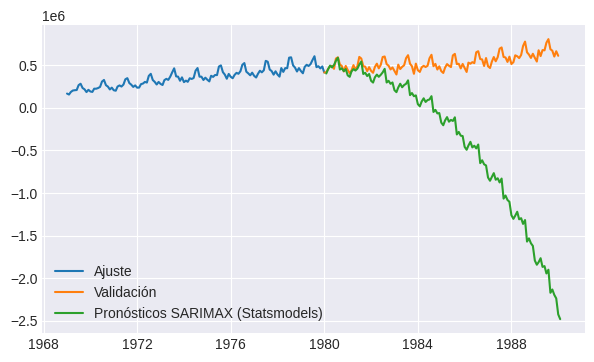

In [ ]:
plt.figure(figsize = (7, 4))
plt.plot(datos_ajuste, label= 'Ajuste')
plt.plot(datos_validacion, label = 'Validación')
plt.plot(predicciones_statsmodels, label = 'Pronósticos SARIMAX (Statsmodels)')
plt.legend()
plt.plot()

Como vemos, el modelo nos predice los dos primeros años efectivamente. Sin embargo, las predicciones tienden a valores negativos porque la mayoría de nuestros coeficientes son negativos (lo podemos ver en el resumen del modelo)

In [ ]:
modelo = Sarimax(order = (8, 2, 1), seasonal_order = (8, 2, 3, 12))
modelo.fit (y=datos_ajuste)
modelo.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                         SARIMAX Results                                          
==================================================================================================
Dep. Variable:                                    litters   No. Observations:                  133
Model:             SARIMAX(8, 2, 1)x(8, 2, [1, 2, 3], 12)   Log Likelihood               -1229.852
Date:                                    Thu, 28 Sep 2023   AIC                           2501.704
Time:                                            23:21:01   BIC                           2557.834
Sample:                                        01-01-1969   HQIC                          2524.459
                                             - 01-01-1980                                         
Covariance Type:                                      opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9180      0.475     -1.935      0.053      -1.848       0.012
ar.L2         -0.4435      0.736     -0.603      0.547      -1.886       0.999
ar.L3         -0.3621      0.734     -0.493      0.622      -1.801       1.077
ar.L4         -0.3657      0.782     -0.468      0.640      -1.898       1.166
ar.L5         -0.2898      0.833     -0.348      0.728      -1.923       1.343
ar.L6         -0.1201      0.830     -0.145      0.885      -1.748       1.508
ar.L7         -0.0486      0.717     -0.068      0.946      -1.454       1.357
ar.L8          0.0565      0.443      0.127      0.899      -0.813       0.926
ma.L1         -0.8086      0.373     -2.165      0.030      -1.541      -0.077
ar.S.L12      -0.5075    344.214     -0.001      0.999    -675.154     674.139
ar.S.L24      -0.1942    121.425     -0.002      0.999    -238.183     237.794
ar.S.L36      -0.3081    208.234     -0.001      0.999    -408.439     407.823
ar.S.L48      -0.2541    142.703     -0.002      0.999    -279.946     279.438
ar.S.L60      -0.2874    110.949     -0.003      0.998    -217.744     217.169
ar.S.L72      -0.1176     95.207     -0.001      0.999    -186.720     186.485
ar.S.L84      -0.0279     30.686     -0.001      0.999     -60.171      60.115
ar.S.L96      -0.0076     19.623     -0.000      1.000     -38.468      38.453
ma.S.L12      -0.5051    344.395     -0.001      0.999    -675.507     674.497
ma.S.L24      -0.1652    227.715     -0.001      0.999    -446.478     446.147
ma.S.L36       0.3341    139.280      0.002      0.998    -272.649     273.317
sigma2      9.826e+08      0.001   9.78e+11      0.000    9.83e+08    9.83e+08
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 7.57
Prob(Q):                              0.98   Prob(JB):                         0.02
Heteroskedasticity (H):               1.50   Skew:                            -0.32
Prob(H) (two-sided):                  0.23   Kurtosis:                         4.14
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 6.02e+28. Standard errors may be unstable.
"""

In [ ]:
predicciones_skforecast = modelo.predict(steps = len(datos_validacion))
predicciones_skforecast.head()

,pred
1980-02-01,402422.230407
1980-03-01,453315.869469
1980-04-01,495714.026842
1980-05-01,473721.090324
1980-06-01,502365.142142


[]

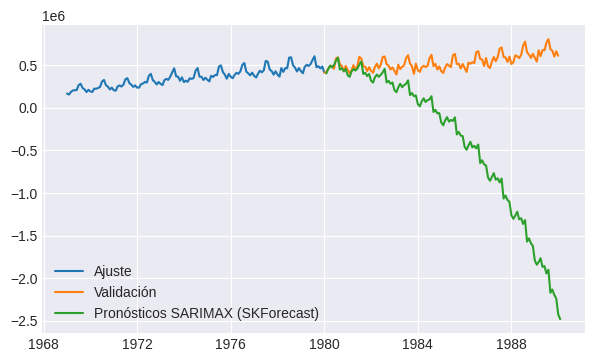

In [ ]:
plt.figure(figsize = (7, 4))
plt.plot(datos_ajuste, label= 'Ajuste')
plt.plot(datos_validacion, label = 'Validación')
plt.plot(predicciones_skforecast, label = 'Pronósticos SARIMAX (SKForecast)')
plt.legend()
plt.plot()

In [ ]:
modelo = ARIMA(order = (8, 2, 1), seasonal_order = (8, 2, 3, 12))
modelo.fit(y = datos_ajuste)
modelo.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                         SARIMAX Results                                          
==================================================================================================
Dep. Variable:                                          y   No. Observations:                  133
Model:             SARIMAX(8, 2, 1)x(8, 2, [1, 2, 3], 12)   Log Likelihood               -1229.866
Date:                                    Thu, 28 Sep 2023   AIC                           2503.732
Time:                                            23:23:16   BIC                           2562.534
Sample:                                        01-01-1969   HQIC                          2527.570
                                             - 01-01-1980                                         
Covariance Type:                                      opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   -236.2253   9.68e+05     -0.000      1.000    -1.9e+06     1.9e+06
ar.L1         -0.9372      0.466     -2.009      0.044      -1.851      -0.023
ar.L2         -0.4752      0.732     -0.649      0.516      -1.910       0.959
ar.L3         -0.3894      0.764     -0.510      0.610      -1.887       1.108
ar.L4         -0.3902      0.848     -0.460      0.646      -2.053       1.273
ar.L5         -0.3172      0.860     -0.369      0.712      -2.002       1.368
ar.L6         -0.1430      0.833     -0.172      0.864      -1.775       1.489
ar.L7         -0.0607      0.725     -0.084      0.933      -1.481       1.360
ar.L8          0.0539      0.449      0.120      0.904      -0.826       0.934
ma.L1         -0.8065      0.363     -2.224      0.026      -1.517      -0.096
ar.S.L12      -0.7736   6707.221     -0.000      1.000   -1.31e+04    1.31e+04
ar.S.L24      -0.6168    977.382     -0.001      0.999   -1916.251    1915.017
ar.S.L36      -0.6757   3448.983     -0.000      1.000   -6760.558    6759.206
ar.S.L48      -0.5157   2338.447     -0.000      1.000   -4583.788    4582.756
ar.S.L60      -0.4555   1972.827     -0.000      1.000   -3867.126    3866.215
ar.S.L72      -0.2387   1812.418     -0.000      1.000   -3552.513    3552.036
ar.S.L84      -0.1034    462.763     -0.000      1.000    -907.103     906.896
ar.S.L96      -0.0371    396.485  -9.35e-05      1.000    -777.133     777.059
ma.S.L12      -0.2264   6707.200  -3.38e-05      1.000   -1.31e+04    1.31e+04
ma.S.L24      -0.0170   5730.001  -2.96e-06      1.000   -1.12e+04    1.12e+04
ma.S.L36       0.3122   3409.075   9.16e-05      1.000   -6681.352    6681.977
sigma2      9.825e+08    899.048   1.09e+06      0.000    9.83e+08    9.83e+08
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 7.45
Prob(Q):                              0.97   Prob(JB):                         0.02
Heteroskedasticity (H):               1.50   Skew:                            -0.31
Prob(H) (two-sided):                  0.23   Kurtosis:                         4.14
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 4.74e+21. Standard errors may be unstable.
"""

In [ ]:
predicciones_pmdarima = modelo.predict(len(datos_validacion))
predicciones_pmdarima.name = 'predicciones_pmdarima'
predicciones_pmdarima.head()

1980-02-01    402737.168197
1980-03-01    451194.242453
1980-04-01    494729.200787
1980-05-01    471053.815553
1980-06-01    499785.625370
Freq: MS, Name: predicciones_pmdarima, dtype: float64

[]

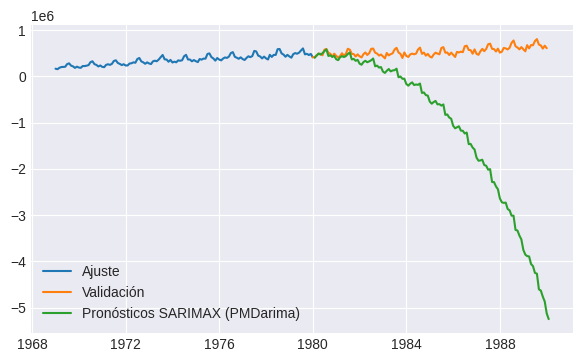

In [ ]:
plt.figure(figsize = (7, 4))
plt.plot(datos_ajuste, label= 'Ajuste')
plt.plot(datos_validacion, label = 'Validación')
plt.plot(predicciones_pmdarima, label = 'Pronósticos SARIMAX (PMDarima)')
plt.legend()
plt.plot()

#Estrategia backtesting

Consiste en probar de forma previa un modelo de series de tiempo basado en la implementación de un mecanismo de validación cruzada.

In [ ]:
regressor = Sarimax(order = (1, 1, 1), seasonal_order = (1, 1, 1, 12))
forecaster = ForecasterSarimax(regressor = regressor)

metrica, predicciones = backtesting_sarimax(forecaster = forecaster,
                                            y= datos,
                                            initial_train_size = len(datos_ajuste),
                                            steps = 12, #Como hay una estacionalidad cada año, que lo haga de 12 en 12
                                            metric = 'mean_absolute_error',
                                            refit = True,
                                            n_jobs = 'auto',
                                            suppress_warnings_fit = True,
                                            verbose = True,
                                            show_progress = True)

Information of backtesting process
----------------------------------
Number of observations used for initial training: 133
Number of observations used for backtesting: 120
    Number of folds: 10
    Number of steps per fold: 12
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   1969-01-01 00:00:00 -- 1980-01-01 00:00:00  (n=133)
    Validation: 1980-02-01 00:00:00 -- 1981-01-01 00:00:00  (n=12)
Fold: 1
    Training:   1970-01-01 00:00:00 -- 1981-01-01 00:00:00  (n=133)
    Validation: 1981-02-01 00:00:00 -- 1982-01-01 00:00:00  (n=12)
Fold: 2
    Training:   1971-01-01 00:00:00 -- 1982-01-01 00:00:00  (n=133)
    Validation: 1982-02-01 00:00:00 -- 1983-01-01 00:00:00  (n=12)
Fold: 3
    Training:   1972-01-01 00:00:00 -- 1983-01-01 00:00:00  (n=133)
    Validation: 1983-02-01 00:00:00 -- 1984-01-01 00:00:00  (n=12)
Fold: 4
    Training:   1973-01-01 00:00:00 -- 1984-01-01 00:00:00  (n=133)
    Validation: 1984-02-01 00:00:00 --

  0%|          | 0/10 [00:00<?, ?it/s]

In [ ]:
print(f'Métrica (MAE): {metrica}') #Error medio absoluto
predicciones

Métrica (MAE): 20528.190767253658


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,pred
1980-02-01,407504.056923
1980-03-01,473997.245798
1980-04-01,489983.091496
1980-05-01,485517.462855
1980-06-01,504445.207331
...,...
1989-09-01,700291.918766
1989-10-01,681322.871603
1989-11-01,635027.760962
1989-12-01,689024.418824


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


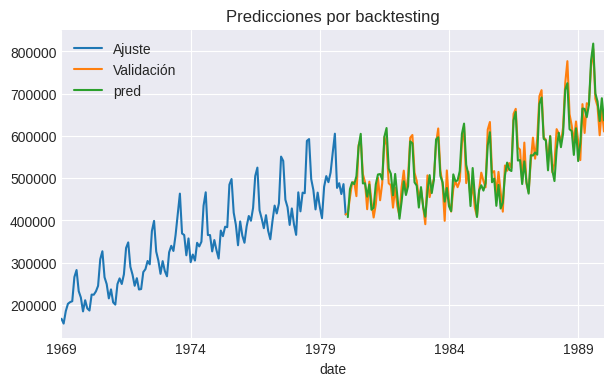

In [ ]:
fig, ax = plt.subplots(figsize = (7, 4))
datos_ajuste.plot(label= 'Ajuste', ax = ax)
datos_validacion.plot(label= 'Validación', ax = ax)
predicciones.plot(label = 'Pronósticos', ax = ax)
ax.set_title('Predicciones por backtesting')
ax.legend()
plt.show()

#Ajuste de parámetros

No hay necesidad de sacar pdq, PDQ a mano. Podemos hayar los mejores valores mediante metodos de ajuste.

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


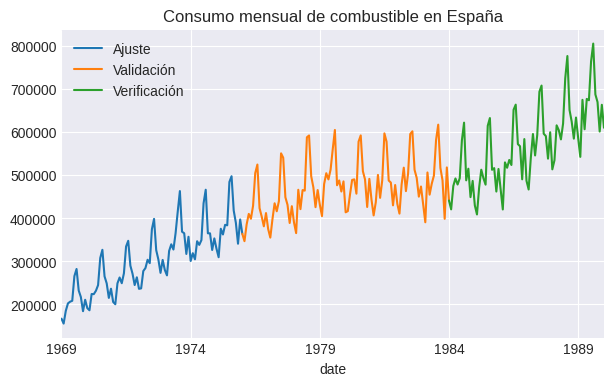

In [ ]:
fin_ajuste = '1976-01-01'
fin_validacion = '1984-01-01'

fig, ax = plt.subplots(figsize = (7, 4))
datos.loc[:fin_ajuste].plot(ax = ax, label = 'Ajuste')
datos.loc[fin_ajuste:fin_validacion].plot(ax = ax, label = 'Validación')
datos.loc[fin_validacion:].plot(ax = ax, label = 'Verificación')
ax.set_title('Consumo mensual de combustible en España')
ax.legend()

Ajuste de modelos basado en backtesting

El criterio de akaike intenta alcanzar el menos valor de una diferencia logaritmica asignandole valores a P, D y Q.

In [ ]:
forecaster = ForecasterSarimax(regressor = Sarimax(order = (1 ,1 ,1), maxiter = 500))
param_grid = {'order': [(0, 1, 0), (1, 1, 0), (1, 1, 1), (2, 1, 1), (4, 2, 1)],
              'seasonal_order':[(0, 0, 0, 0), (0, 1, 0, 12), (1, 1, 1, 12), (4, 2, 2, 12)]}
resultados_grid = grid_search_sarimax(forecaster = forecaster,
                                      y= datos.loc[:fin_validacion],
                                      param_grid = param_grid,
                                      steps= 12,
                                      refit= True,
                                      initial_train_size = len(datos_ajuste),
                                      fixed_train_size = False,
                                      return_best = False,
                                      n_jobs = 'auto',
                                      suppress_warnings_fit = True,
                                      verbose = False,
                                      show_progress = True,
                                      metric = 'mean_absolute_error')

Number of models compared: 20.


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


params grid:   0%|          | 0/20 [00:00<?, ?it/s]

In [ ]:
resultados_grid

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,params,mean_absolute_error,order,seasonal_order
10,"{'order': (1, 1, 1), 'seasonal_order': (1, 1, ...",19897.376861,"(1, 1, 1)","(1, 1, 1, 12)"
14,"{'order': (2, 1, 1), 'seasonal_order': (1, 1, ...",20176.735883,"(2, 1, 1)","(1, 1, 1, 12)"
6,"{'order': (1, 1, 0), 'seasonal_order': (1, 1, ...",20228.826352,"(1, 1, 0)","(1, 1, 1, 12)"
2,"{'order': (0, 1, 0), 'seasonal_order': (1, 1, ...",20241.069364,"(0, 1, 0)","(1, 1, 1, 12)"
18,"{'order': (4, 2, 1), 'seasonal_order': (1, 1, ...",21717.285474,"(4, 2, 1)","(1, 1, 1, 12)"
9,"{'order': (1, 1, 1), 'seasonal_order': (0, 1, ...",23766.311791,"(1, 1, 1)","(0, 1, 0, 12)"
13,"{'order': (2, 1, 1), 'seasonal_order': (0, 1, ...",23846.950304,"(2, 1, 1)","(0, 1, 0, 12)"
17,"{'order': (4, 2, 1), 'seasonal_order': (0, 1, ...",23850.780922,"(4, 2, 1)","(0, 1, 0, 12)"
15,"{'order': (2, 1, 1), 'seasonal_order': (4, 2, ...",24296.749224,"(2, 1, 1)","(4, 2, 2, 12)"
5,"{'order': (1, 1, 0), 'seasonal_order': (0, 1, ...",24429.644236,"(1, 1, 0)","(0, 1, 0, 12)"


Ajuste basado en criterio de Akaike

In [ ]:
modelo = auto_arima(y = datos.loc[:fin_validacion],
                    start_p = 0,
                    start_q = 0,
                    max_p = 8,
                    max_q = 3,
                    seasonal = True, #Es estacional o no? En este caso sí
                    test = 'adf',
                    m = 12,
                    d = None, #No le damos d ni D para que él la ajuste
                    D = None,
                    trace = True,
                    error_action = 'ignore',
                    suppress_warnings = True,
                    stepwise = True)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=3903.204, Time=0.33 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=3942.897, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=3846.786, Time=0.24 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=3840.318, Time=0.33 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=3873.797, Time=0.13 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=3841.882, Time=0.53 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=3841.572, Time=1.85 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=3852.231, Time=0.32 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=3842.593, Time=2.85 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=3904.615, Time=0.18 sec
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=3834.135, Time=0.53 sec
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=3866.187, Time=0.15 sec
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=3835.564, Time=0.50 sec
 ARIMA(1,1,1)(0,1,2)[12]             : AIC=3835.160, Time=3.21 sec
 ARIMA(1,1,1)(1,1,0

#Predicciones usando backstesting con los mejores modelos

In [ ]:
#GridSearch
forecaster = ForecasterSarimax(regressor = Sarimax(order = (1, 1, 1), seasonal_order = (1, 1, 1, 12), maxiter= 500))
metrica_m1, predicciones_m1 = backtesting_sarimax(forecaster = forecaster,
                                                  y= datos,
                                                  initial_train_size = len(datos.loc[:fin_validacion]),
                                                  steps = 12,
                                                  metric = 'mean_absolute_error',
                                                  refit = True,
                                                  n_jobs = 'auto',
                                                  suppress_warnings_fit = True,
                                                  verbose = False,
                                                  show_progress = True)

#Autoarima
forecaster = ForecasterSarimax(regressor = Sarimax(order = (1, 1, 1), seasonal_order = (0, 1, 1, 12), maxiter= 500))
metrica_m2, predicciones_m2 = backtesting_sarimax(forecaster = forecaster,
                                                  y= datos,
                                                  initial_train_size = len(datos.loc[:fin_validacion]),
                                                  steps = 12,
                                                  metric = 'mean_absolute_error',
                                                  refit = True,
                                                  n_jobs = 'auto',
                                                  suppress_warnings_fit = True,
                                                  verbose = False,
                                                  show_progress = True)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

In [ ]:
print(f'Metrica (MAE) Grid Search: {metrica_m1}')
print(f'Métrica (MAE) Auto ARIMA: {metrica_m2}')

Metrica (MAE) Grid Search: 20222.908912942763
Métrica (MAE) Auto ARIMA: 20149.352203471986


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
predicciones_m1 = predicciones_m1.rename(columns = {'pred':'GridSearch'})
predicciones_m2 = predicciones_m2.rename(columns = {'pred': 'AutoArima'})

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/pandas/plotting/_matplotlib/core.py:792: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  handles = leg.legendHandles


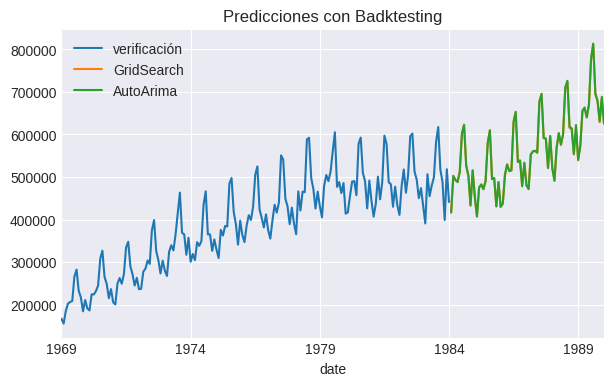

In [ ]:
fig, ax = plt.subplots(figsize = (7,4))
datos.loc[:fin_validacion].plot(ax = ax, label = 'verificación')
predicciones_m1.plot(ax = ax)
predicciones_m2.plot(ax = ax)
ax.set_title('Predicciones con Badktesting')
ax.legend()